In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_missing_40 = train_missing[train_missing.percent<0.4].index
test_missing_40 =  test_missing[test_missing.percent<0.4].index
train_missing_15 = train_missing[train_missing.percent<0.15].index
test_missing_15 =  test_missing[test_missing.percent<0.15].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features_40 = set(train_missing_40) & set(test_missing_40)
features_15 = set(train_missing_15) & set(test_missing_15)
features = set(features_40) - set(categorical_features)
knn_features = set(features) - set(features_15)  

In [10]:
len(features), len(knn_features)

(2259, 512)

In [11]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]
knn_features = [col for col in knn_features if col not in land_sat_feats]

In [12]:
len(features), len(knn_features)

(309, 62)

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

missing_train = train.fillna(9999)
missing_test = test.fillna(9999)

for mcol in tqdm(knn_features):
    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]
    knn_train = missing_train.loc[missing_train[mcol]!=9999]
    knn_mtest = missing_test.loc[missing_test[mcol]==9999]

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(knn_train[features],knn_train[mcol])
    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])

    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")
    train[mcol] = train[mcol].fillna(0)
    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)
    train[mcol] = train[mcol] + train[f"knn_{mcol}"]

    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")
    test[mcol] = test[mcol].fillna(0)
    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].fillna(0)
    test[mcol] = test[mcol] + test[f"knn_{mcol}"]

display(train[knn_features].head(10))
display(test[knn_features].head(10))

  0%|          | 0/62 [00:00<?, ?it/s]<ipython-input-13-b25a66a67f2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
<ipython-input-13-b25a66a67f2a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])
  2%|▏         | 1/62 [00:03<03:40,  3.62s/it]<ipython-input-13-b25a66a67f2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,mCRIG,IR550,Ferric_Oxides,GEMI,Landsat_num,sunAzimuth,TSAVI,CTVI,NDWI,H,...,NBR2,Ferrous_Silicates,Fe3,DVIMSS,RDVI,NIR,Chlred_edge,mCRIRE,TIRS1,TIRS2
0,-0.082768,0.040873,0.061078,-65.107007,7.0,147.348267,-0.716042,0.410823,0.689504,1.536542,...,0.369581,0.460301,0.502376,-1.499917,-1.902453,4.496400,2.733582,-0.264809,8.243456,8.218559
1,-0.049793,0.013727,0.090641,-351.833930,7.0,95.422757,0.072192,0.568762,0.017501,1.410671,...,0.724646,0.159658,0.699943,117.831956,1.756928,70.342323,0.724878,-0.463735,8.649507,8.658948
2,-0.072468,0.028836,0.081935,-120.471556,7.0,151.061766,-0.638658,0.441918,0.631929,1.532755,...,0.697570,0.178154,0.532909,0.291149,-2.078368,7.821566,2.362776,-0.270155,8.279950,8.255633
3,-0.102928,0.021359,0.088156,-127.003226,7.0,127.929376,-0.346838,0.580183,0.324695,1.495565,...,0.722703,0.161917,0.720089,26.308228,-1.239537,25.018325,1.554244,-0.300630,8.857862,8.838449
4,-0.070236,0.032890,0.047640,-32.365638,7.0,153.361999,-0.601136,-0.089450,0.743429,1.554811,...,0.710619,0.169168,0.326259,0.818969,-1.435234,4.474403,2.216966,-0.374138,8.385872,8.375682
5,-0.102928,0.021359,0.088156,-127.003226,7.0,127.929376,-0.346838,0.580183,0.324695,1.495565,...,0.722703,0.161917,0.720089,26.308228,-1.239537,25.018325,1.554244,-0.300630,8.857862,8.838449
6,-0.084250,0.033065,0.080216,-79.293798,7.0,151.061766,-0.633086,0.404647,0.649978,1.540411,...,0.709369,0.170023,0.496713,0.375503,-1.858805,6.415680,2.341471,-0.299195,8.251698,8.259885
7,-0.025008,0.018070,0.127199,-206.976268,8.0,128.531133,-0.867709,0.130981,0.827863,1.554245,...,0.634860,0.223346,0.348759,-6.792398,-2.845638,5.211494,3.703350,-0.200860,8.843853,7.987241
8,-0.080573,0.025985,0.105604,-99.085508,7.0,126.264466,-0.599333,0.358983,0.655387,1.551772,...,0.620597,0.234113,0.458650,1.576855,-1.902817,8.011537,2.203177,-0.326286,9.141504,9.141788
9,-0.081238,0.038088,0.094146,-49.117164,7.0,153.816328,-0.640413,0.337943,0.685610,1.540390,...,0.683367,0.188095,0.443215,0.116010,-1.657504,4.896877,2.376309,-0.315544,8.520046,8.492517


,mCRIG,IR550,Ferric_Oxides,GEMI,Landsat_num,sunAzimuth,TSAVI,CTVI,NDWI,H,...,NBR2,Ferrous_Silicates,Fe3,DVIMSS,RDVI,NIR,Chlred_edge,mCRIRE,TIRS1,TIRS2
0,-0.102928,0.021359,0.088156,-127.003226,7.0,127.929376,-0.346838,0.580183,0.324695,1.495565,...,0.722703,0.161917,0.720089,26.308228,-1.239537,25.018325,1.554244,-0.300630,8.857862,8.838449
1,-0.097787,0.030744,0.100038,-50.269846,7.0,128.573050,-0.463083,0.324673,0.597267,1.544322,...,0.625434,0.231634,0.438826,5.478744,-1.330266,8.606872,1.749661,-0.418280,8.792016,8.814009
2,-0.108825,0.021419,0.086700,-90.264924,7.0,127.929376,-0.303412,0.581877,0.295492,1.497484,...,0.707265,0.173532,0.722763,28.968576,-1.047965,26.142190,1.390758,-0.316523,8.868892,8.837255
3,-0.069664,0.034843,0.068374,-54.702543,7.0,138.032189,-0.711587,0.254681,0.746567,1.552029,...,0.787176,0.119084,0.393594,-1.301446,-1.813769,4.164535,2.712507,-0.293223,8.604989,8.568386
4,-0.035106,0.023751,0.084139,-351.078729,8.0,154.492638,-0.928132,0.478249,0.761533,1.529995,...,0.665161,0.201085,0.573220,-10.455337,-3.375080,5.699820,4.234328,-0.135897,8.590875,7.937538
5,-0.107664,0.022092,0.085772,-89.876426,7.0,127.929376,-0.337300,0.570722,0.326208,1.503037,...,0.708617,0.172488,0.706031,26.774289,-1.131492,24.570061,1.514408,-0.313834,8.869017,8.838213
6,-0.085535,0.034199,0.053720,-50.800409,7.0,153.816328,-0.601392,0.313967,0.676659,1.547764,...,0.560829,0.281370,0.427119,1.044402,-1.608881,5.638958,2.214788,-0.344197,8.520046,8.549272
7,-0.050608,0.026830,0.126179,-98.665395,8.0,132.150790,-0.752735,0.253065,0.763572,1.550916,...,0.614958,0.238423,0.392799,-2.648215,-2.176225,4.996790,2.929983,-0.257846,9.294236,8.479495
8,-0.082478,0.035531,0.085077,-48.937543,7.0,153.816328,-0.588053,0.338970,0.659443,1.538688,...,0.812505,0.103445,0.443940,1.367738,-1.571816,5.775920,2.163200,-0.339532,8.452959,8.483115
9,-0.102928,0.021359,0.088156,-127.003226,7.0,127.929376,-0.346838,0.580183,0.324695,1.495565,...,0.722703,0.161917,0.720089,26.308228,-1.239537,25.018325,1.554244,-0.300630,8.857862,8.838449


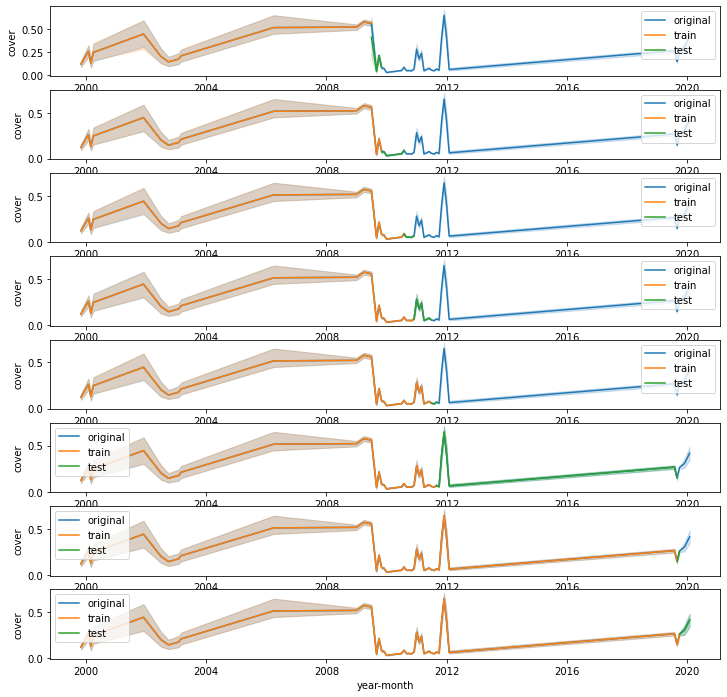

In [14]:
from sklearn.model_selection import TimeSeriesSplit

fig, axes = plt.subplots(8, 1, figsize=(12, 12))

train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)

folds = TimeSeriesSplit(n_splits=8)

for i, (train_index, test_index) in enumerate(folds.split(train)):

    sns.lineplot(data=train, x='year-month', y='cover', ax=axes[i], label='original')
    # 学習用データを描く
    sns.lineplot(data=train.iloc[train_index], x='year-month', y='cover', ax=axes[i], label='train')
    # テスト用データを描く
    sns.lineplot(data=train.iloc[test_index], x='year-month', y='cover', ax=axes[i], label='test')

# グラフを表示する
plt.legend()
plt.show()

## Model

In [15]:
#!pip install iterative-stratification

In [16]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [17]:
class CFG:
  ver=60
  model="lightgbm"
  n_folds=8
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover"
  boosting_type="gbdt"
  fold_target1="adv_flag"
  fold_target2="cover"
  fold_target3="cover"

In [18]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df, fold_target, isFlag=False):
  if isFlag:
    Fold = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = TimeSeriesSplit(n_splits=CFG.n_folds)
    for n, (train_index, val_index) in enumerate(Fold.split(df)):
      df.loc[train_index, f'tr_fold{n}'] = 1
      df.loc[val_index, 'va_fold'] = int(n)
      df[f"tr_fold{n}"] = df[f"tr_fold{n}"].fillna(0)
      df[f'tr_fold{n}'] = df[f'tr_fold{n}'].astype(int)
  df["va_fold"] = df["va_fold"].fillna(999)
  df['va_fold'] = df['va_fold'].astype(int)
  return df

In [19]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [20]:
#features = list(features)
features.remove('id')
features.remove('area')
features.remove("year")
#features.remove("month")
features.append("mesh20")

In [21]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [22]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  ctg_list = ["year","month","mesh20"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train[f'tr_fold{fold}'] == 1]
      valid_folds = train[train['va_fold'] == fold]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 200,
              early_stopping_rounds=50)
      
      if isFlag:
        pred = model.predict(valid_X)
        predict_proba = model.predict_proba(valid_X)
        valid_folds["Zscore"] = predict_proba[:,1]
        valid_folds[f"{pred_name}_pred"] = pred
      else:
        valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
        test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  if isFlag:
    return oof_df
  else:
    return oof_df,  test_preds

In [23]:
# 傾向スコアマッチング関数
def matching(result1, z_col='Zscore', tr_col="adv_flag", match_id='id'):
    '''
    result1: 介入変数、傾向スコア、共変量のデータフレーム
    '''
    # キャリパー設定
    caliper = result1[z_col].std()*0.2

    # 処置群抽出
    Tr = result1[result1[tr_col]>0][[match_id, z_col]].copy().reset_index(drop=True)
    Tr.index = Tr[match_id]
    # 対照群抽出
    Ctl = result1[result1[tr_col]==0][[match_id, z_col]].copy().reset_index(drop=True)
    Ctl.index = Ctl[match_id]
    
    Ctl_vals = np.copy(Ctl[z_col].to_numpy()) # 配列化
    Ctl_ids = np.copy(Ctl.index.to_numpy()) # 配列化
    Tr_vals_dict = Tr[z_col].sort_values(ascending=False).to_dict() # 処置群の傾向スコアで降順にして辞書化

    # マッチングを実施していく
    match_results = [] # 結果を入れる箱
    for i, (cid, tr_val) in tqdm(enumerate(Tr_vals_dict.items())):
        # cid:user_id, tr_val:傾向スコア
        # argminで処置群と最も傾向スコアの差が小さい対照群のインデックス番号取得
        nearId = np.abs(Ctl_vals - tr_val).argmin()
        # 傾向スコアの差がキャリパーより大きかった場合、マッチングしない
        if np.abs(tr_val-Ctl_vals[nearId])>caliper:
            continue
        # 傾向スコアの差がキャリパーより小さかった場合、マッチングした者同士をリストに格納
        match_results.append([cid, Ctl_ids[nearId], tr_val, Ctl_vals[nearId]])
        # 次のマッチングで重複してマッチングしないように対照群のスコアを-9999に置き換える
        np.put(Ctl_vals, [nearId], -9999)

    # リストをdf化
    match_results_df = pd.DataFrame(match_results, columns=['Tr', 'Ctl', 'Tr_zscore', 'Ctl_zscore'])
    match_results_df['diff'] = np.abs(match_results_df['Tr_zscore']-match_results_df['Ctl_zscore'])
    print(match_results_df['diff'].max())
    return match_results_df

In [24]:
#model1 = lgb.LGBMClassifier(**params1)
#flag_oof = get_pred(df, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)

In [25]:
#match_results_df = matching(flag_oof, z_col='Zscore', tr_col='adv_flag', match_id='id')
#display(match_results_df)

In [26]:
#match_id = match_results_df.Ctl.tolist()
#match_train = train[train["id"].isin(match_id)].reset_index(drop=True)
#display(match_train)

===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年7.0月
valid period : 2009.0年7.0月 ～ 2009.0年11.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[55]	valid_0's rmse: 0.147904
RMSE 0.14790280852481996
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年11.0月

<ipython-input-22-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)



valid period : 2009.0年11.0月 ～ 2010.0年8.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[37]	valid_0's rmse: 0.156139
RMSE 0.15613909089376515
===============  FOLD : 2  ===============


<ipython-input-22-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年12.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[40]	valid_0's rmse: 0.0808047
RMSE 0.08080469589144232
===============  FOLD : 3  ===============


<ipython-input-22-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年7.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[44]	valid_0's rmse: 0.139552


<ipython-input-22-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.1395524946489783
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.132889


<ipython-input-22-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.13288865584603185
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2019.0年9.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.226976


<ipython-input-22-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.22697633713162133
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.240585
Early stopping, best iteration is:
[266]	valid_0's rmse: 0.240047


<ipython-input-22-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.24004667293578566
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.201614
Early stopping, best iteration is:
[265]	valid_0's rmse: 0.201245


<ipython-input-22-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.2012453776303813


,feature,importance
41,lat,0.018277
162,warm_sst,0.017415
149,sst_ymd,0.014104
17,month,0.013469
267,hist_warm_sst,0.012381
237,fetch,0.012336
167,MIN_D678_500,0.011701
253,depth,0.011066
286,river_dist,0.010794
278,sst_diff,0.010703


RMSE 0.17304577204850669


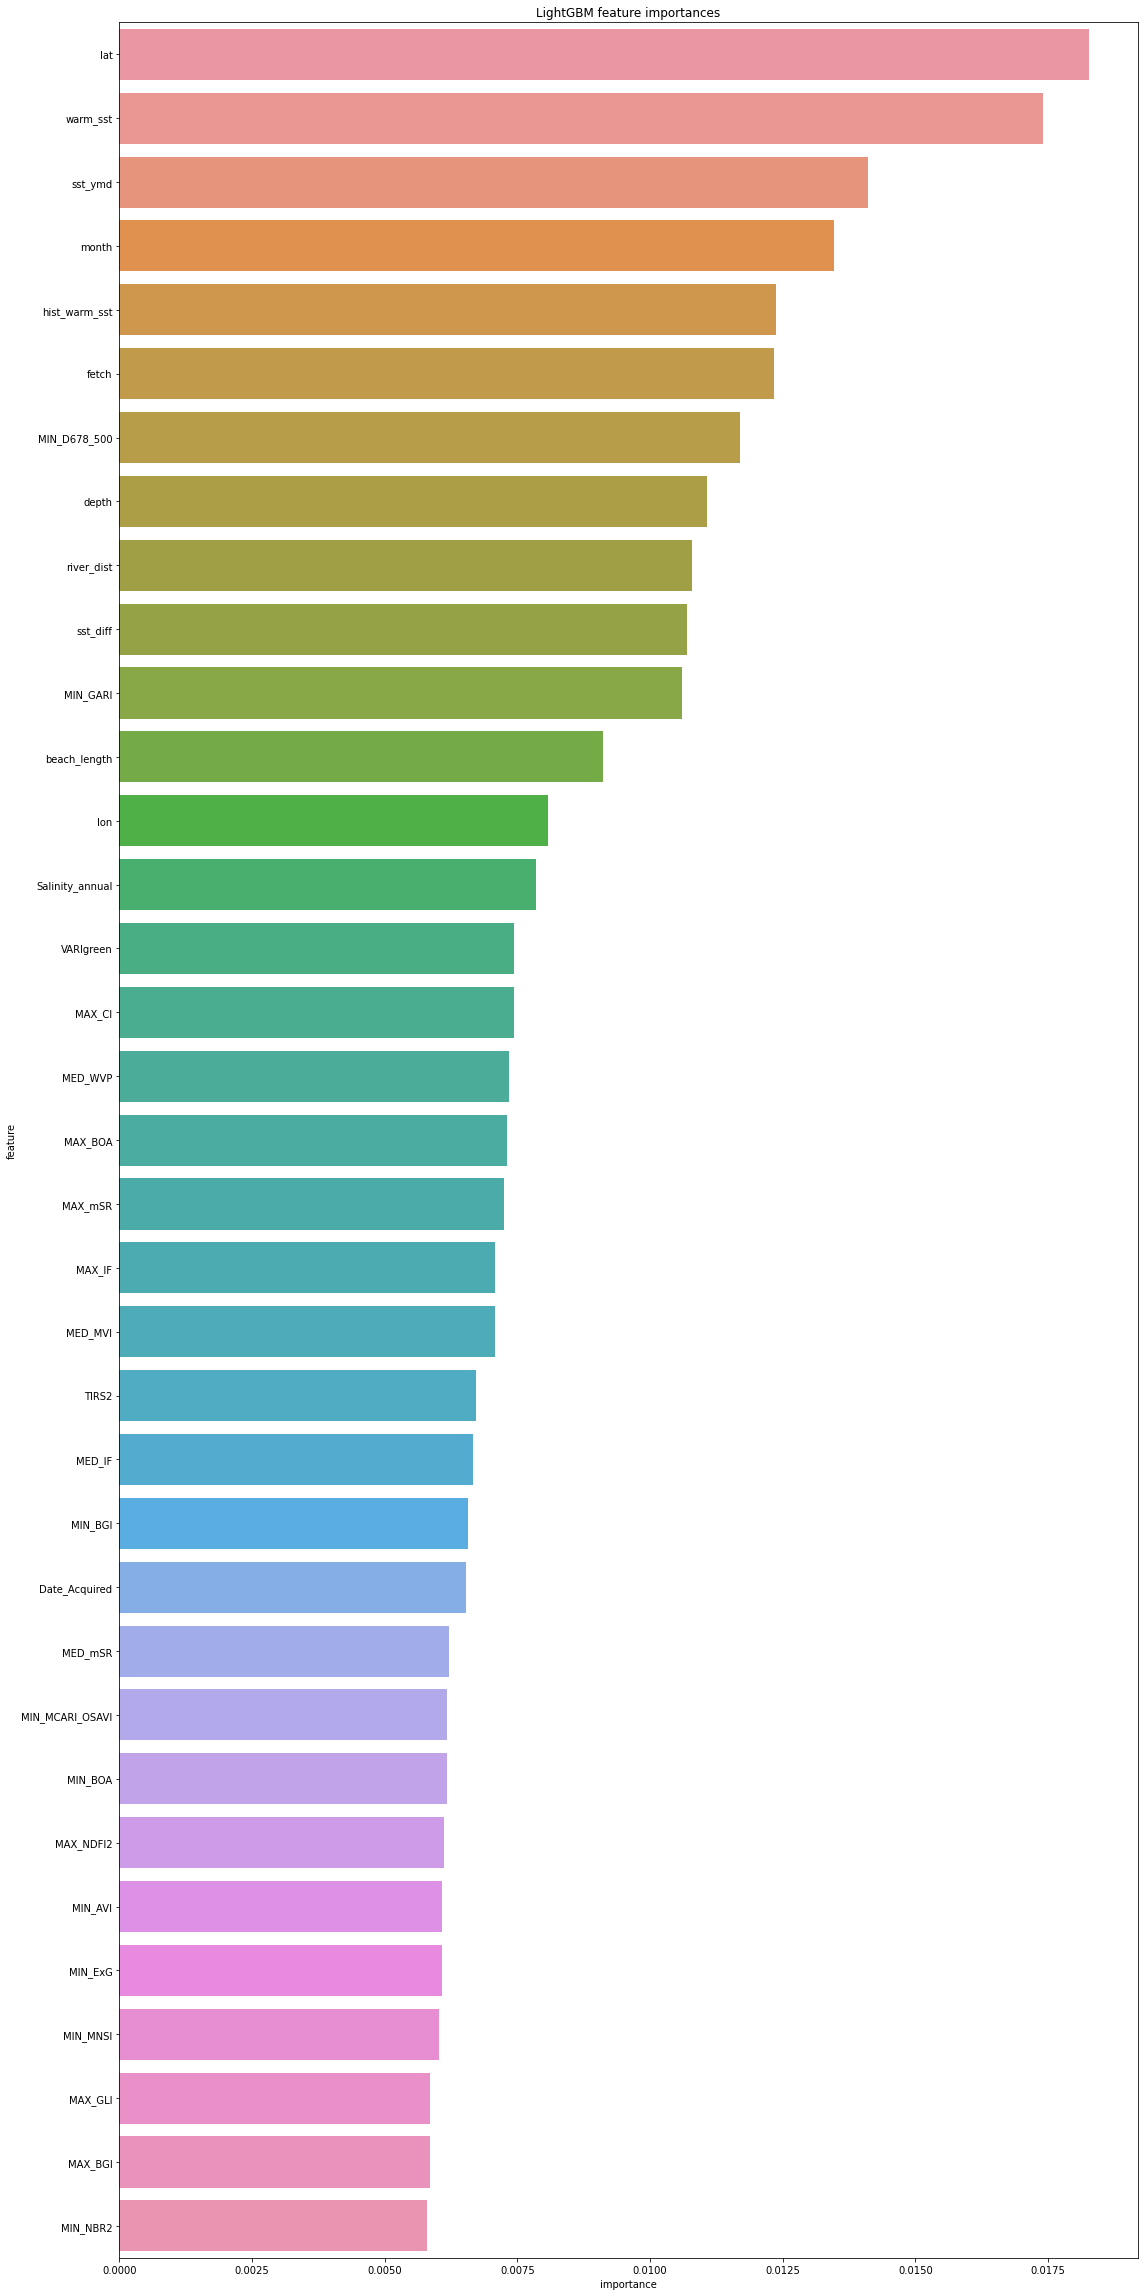

In [27]:
model2 = lgb.LGBMRegressor(**params2)
oof_df, test_pred = get_pred(train, test, CFG.fold_target3, CFG.target_cols2, model2)

In [28]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["_pred"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.17297655893406666


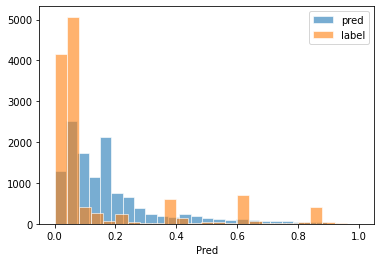

In [29]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [30]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_Ferrous_Silicates,knn_Fe3,knn_DVIMSS,knn_RDVI,knn_NIR,knn_Chlred_edge,knn_mCRIRE,knn_TIRS1,knn_TIRS2,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.161917,0.720089,26.308228,-1.239537,25.018325,1.554244,-0.300630,8.857862,8.838449,0.064573
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.231634,0.438826,5.478744,-1.330266,8.606872,1.749661,-0.418280,8.792016,8.814009,0.126445
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.173532,0.722763,28.968576,-1.047965,26.142190,1.390758,-0.316523,8.868892,8.837255,0.075362
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072997
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094190
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108696
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.161917,0.720089,26.308228,-1.239537,25.018325,1.554244,-0.300630,8.857862,8.838449,0.269278
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.167826


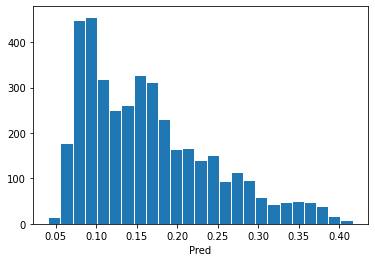

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_Ferrous_Silicates,knn_Fe3,knn_DVIMSS,knn_RDVI,knn_NIR,knn_Chlred_edge,knn_mCRIRE,knn_TIRS1,knn_TIRS2,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.161917,0.720089,26.308228,-1.239537,25.018325,1.554244,-0.300630,8.857862,8.838449,0.064573
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.231634,0.438826,5.478744,-1.330266,8.606872,1.749661,-0.418280,8.792016,8.814009,0.126445
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.173532,0.722763,28.968576,-1.047965,26.142190,1.390758,-0.316523,8.868892,8.837255,0.075362
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072997
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094190
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108696
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,0.161917,0.720089,26.308228,-1.239537,25.018325,1.554244,-0.300630,8.857862,8.838449,0.269278
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.167826


In [31]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)